# Advanced Linear Regression Model für Bäckerei Umsatzvorhersage

Dieses Notebook implementiert ein erweitertes Regressionsmodell, das für jede Warengruppe ein separates LinearRegression-Modell trainiert. Dies ermöglicht präzisere Vorhersagen durch spezifische Modellierung der Zusammenhänge pro Produktkategorie.

## Aufgabenstellung:
- **Datensatz**: bakery_training_dataset.csv
- **Ziel**: Separate Vorhersagemodelle für jede Warengruppe (1-6)
- **Zeitraum**: 
  - Training: 2013-07-01 bis 2017-07-31
  - Validation: 2017-08-01 bis 2018-07-31
  - Test: 2018-08-01 bis 2019-07-31
- **Features**: Temperatur, Windgeschwindigkeit, Bewölkung, Zeitvariablen, Dummies für Feiertage/Wochentage/Jahreszeiten

## 1. Bibliotheken importieren

In [60]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Für reproduzierbare Ergebnisse
np.random.seed(42)

## 2. Daten laden und vorbereiten

In [61]:
# Datensatz laden
df = pd.read_csv('/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv')

# Datum als datetime parsen
df['Datum'] = pd.to_datetime(df['Datum'])

# Überprüfen der Daten
print(f"Datensatz Form: {df.shape}")
print(f"Anzahl der Warengruppen: {df['Warengruppe_Name'].nunique()}")
print(f"Warengruppen: {df['Warengruppe_Name'].unique()}")
df.head()

Datensatz Form: (9334, 34)
Anzahl der Warengruppen: 6
Warengruppen: ['Brot' 'Brötchen' 'Croissant' 'Konditorei' 'Kuchen' 'Saisonbrot']


,Datum,Jahr,Monat,Tag,Wochentag,Wochentag_Nr,Warengruppe,Warengruppe_Name,Temperatur,Windgeschwindigkeit,...,Jahreszeit_Sommer,Jahreszeit_Herbst,Wochentag_Nr.1,Wochentag_Monday,Wochentag_Tuesday,Wochentag_Wednesday,Wochentag_Thursday,Wochentag_Friday,Wochentag_Saturday,Wochentag_Sunday
0,2013-07-01,2013,7,1,Monday,0,1,Brot,17.8375,15.0,...,1,0,0,1,0,0,0,0,0,0
1,2013-07-02,2013,7,2,Tuesday,1,1,Brot,17.3125,10.0,...,1,0,1,0,1,0,0,0,0,0
2,2013-07-03,2013,7,3,Wednesday,2,1,Brot,21.0750,6.0,...,1,0,2,0,0,1,0,0,0,0
3,2013-07-04,2013,7,4,Thursday,3,1,Brot,18.8500,7.0,...,1,0,3,0,0,0,1,0,0,0
4,2013-07-05,2013,7,5,Friday,4,1,Brot,19.9750,12.0,...,1,0,4,0,0,0,0,1,0,0


## 2.1 Datenqualitätsprüfung und Vorverarbeitung

In [62]:
# Datenqualitätsprüfung
print("=== DATENQUALITÄTSPRÜFUNG ===")
print(f"Datensatz Shape: {df.shape}")
print(f"Fehlende Werte pro Spalte:")
print(df.isnull().sum())
print(f"\nDatentypen:")
print(df.dtypes)
print(f"\nDeskriptive Statistiken für numerische Spalten:")
print(df.describe())

=== DATENQUALITÄTSPRÜFUNG ===
Datensatz Shape: (9334, 34)
Fehlende Werte pro Spalte:
Datum                     0
Jahr                      0
Monat                     0
Tag                       0
Wochentag                 0
Wochentag_Nr              0
Warengruppe               0
Warengruppe_Name          0
Temperatur                0
Windgeschwindigkeit       0
Bewoelkung                0
Wettercode_fehlt          0
ist_feiertag              0
Jahreszeit                0
ist_kiwo                  0
Umsatz                    0
Warengruppe_Brot          0
Warengruppe_Brötchen      0
Warengruppe_Croissant     0
Warengruppe_Konditorei    0
Warengruppe_Kuchen        0
Warengruppe_Saisonbrot    0
Jahreszeit_Winter         0
Jahreszeit_Frühling       0
Jahreszeit_Sommer         0
Jahreszeit_Herbst         0
Wochentag_Nr.1            0
Wochentag_Monday          0
Wochentag_Tuesday         0
Wochentag_Wednesday       0
Wochentag_Thursday        0
Wochentag_Friday          0
Wochentag_Saturday 

In [63]:
def handle_missing_values(df):
    """
    Explizite Behandlung fehlender Werte
    """
    df_clean = df.copy()
    
    # Numerische Spalten identifizieren
    numeric_columns = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Umsatz']
    
    # Fehlende Werte in numerischen Spalten mit Median füllen
    for col in numeric_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                median_val = df_clean[col].median()
                df_clean[col].fillna(median_val, inplace=True)
                print(f"Fehlende Werte in {col} ({missing_count}) mit Median ({median_val:.2f}) gefüllt")
    
    # Kategorische Spalten mit Modus füllen
    categorical_columns = ['Warengruppe_Name']
    for col in categorical_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                mode_val = df_clean[col].mode()[0]
                df_clean[col].fillna(mode_val, inplace=True)
                print(f"Fehlende Werte in {col} ({missing_count}) mit Modus ({mode_val}) gefüllt")
    
    # Binäre Spalten mit 0 füllen
    binary_columns = ['ist_feiertag']
    for col in binary_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                df_clean[col].fillna(0, inplace=True)
                print(f"Fehlende Werte in {col} ({missing_count}) mit 0 gefüllt")
    
    return df_clean

def winsorize_outliers(df, columns, lower_percentile=0.01, upper_percentile=0.99):
    """
    Winsorisierung zur Behandlung von Extremwerten
    """
    df_winsorized = df.copy()
    
    for col in columns:
        if col in df_winsorized.columns:
            # Ursprüngliche Verteilung
            original_min = df_winsorized[col].min()
            original_max = df_winsorized[col].max()
            
            # Perzentile berechnen
            lower_bound = df_winsorized[col].quantile(lower_percentile)
            upper_bound = df_winsorized[col].quantile(upper_percentile)
            
            # Anzahl der zu ändernden Werte
            lower_outliers = (df_winsorized[col] < lower_bound).sum()
            upper_outliers = (df_winsorized[col] > upper_bound).sum()
            
            # Winsorisierung durchführen
            df_winsorized[col] = np.clip(df_winsorized[col], lower_bound, upper_bound)
            
            # Ergebnisse anzeigen
            new_min = df_winsorized[col].min()
            new_max = df_winsorized[col].max()
            
            print(f"\n{col}:")
            print(f"  Ursprünglich: [{original_min:.2f}, {original_max:.2f}]")
            print(f"  Nach Winsorisierung: [{new_min:.2f}, {new_max:.2f}]")
            print(f"  Untere Ausreißer ersetzt: {lower_outliers}")
            print(f"  Obere Ausreißer ersetzt: {upper_outliers}")
    
    return df_winsorized

# Fehlende Werte behandeln
print("\n=== BEHANDLUNG FEHLENDER WERTE ===")
df_clean = handle_missing_values(df)

# Winsorisierung anwenden
print("\n=== EXTREMWERTE-WINSORISIERUNG ===")
numeric_cols_for_winsorization = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Umsatz']
df_processed = winsorize_outliers(df_clean, numeric_cols_for_winsorization)

print(f"\nDaten nach Vorverarbeitung: {df_processed.shape}")
print(f"Verbleibende fehlende Werte: {df_processed.isnull().sum().sum()}")


=== BEHANDLUNG FEHLENDER WERTE ===

=== EXTREMWERTE-WINSORISIERUNG ===

Temperatur:
  Ursprünglich: [-8.47, 31.44]
  Nach Winsorisierung: [-3.11, 26.77]
  Untere Ausreißer ersetzt: 90
  Obere Ausreißer ersetzt: 90

Windgeschwindigkeit:
  Ursprünglich: [3.00, 35.00]
  Nach Winsorisierung: [4.00, 23.67]
  Untere Ausreißer ersetzt: 22
  Obere Ausreißer ersetzt: 94

Bewoelkung:
  Ursprünglich: [0.00, 8.00]
  Nach Winsorisierung: [0.00, 8.00]
  Untere Ausreißer ersetzt: 0
  Obere Ausreißer ersetzt: 0

Umsatz:
  Ursprünglich: [7.05, 1879.46]
  Nach Winsorisierung: [39.43, 668.89]
  Untere Ausreißer ersetzt: 94
  Obere Ausreißer ersetzt: 94

Daten nach Vorverarbeitung: (9334, 34)
Verbleibende fehlende Werte: 0


## 3. Feature Engineering

In [64]:
def create_features(df):
    """
    Erstellt alle benötigten Features für die Modellierung, 
    einschließlich der Interaktionsterme.
    """
    df_features = df.copy()
    
    # Zeitbasierte Features
    df_features['Jahr'] = df_features['Datum'].dt.year
    df_features['Monat'] = df_features['Datum'].dt.month
    df_features['Tag'] = df_features['Datum'].dt.day
    df_features['Wochentag_Nr'] = df_features['Datum'].dt.dayofweek  # 0=Montag, 6=Sonntag
    
    # Jahreszeiten kodieren (Frühling als Basiskategorie)
    df_features['Jahreszeit_Winter'] = ((df_features['Monat'] == 12) | 
                                       (df_features['Monat'] == 1) | 
                                       (df_features['Monat'] == 2)).astype(int)
    df_features['Jahreszeit_Sommer'] = ((df_features['Monat'] == 6) | 
                                       (df_features['Monat'] == 7) | 
                                       (df_features['Monat'] == 8)).astype(int)
    df_features['Jahreszeit_Herbst'] = ((df_features['Monat'] == 9) | 
                                       (df_features['Monat'] == 10) | 
                                       (df_features['Monat'] == 11)).astype(int)
    
    # Wochentag One-Hot Encoding (Sonntag als Basiskategorie)
    for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']):
        df_features[f'Wochentag_{day}'] = (df_features['Wochentag_Nr'] == i).astype(int)
    
    # Wettercode-Feature weglassen, wie gewünscht
    
    # Kieler Woche Feature erstellen (Mitte Juni)
    df_features['ist_kiwo'] = ((df_features['Monat'] == 6) & 
                             (df_features['Tag'] >= 15) & 
                             (df_features['Tag'] <= 25)).astype(int)
    
    # Interaktionsterme erstellen
    df_features['Temperatur_x_Jahreszeit_Sommer'] = df_features['Temperatur'] * df_features['Jahreszeit_Sommer']
    df_features['ist_feiertag_x_Wochentag_Sunday'] = df_features['ist_feiertag'] * (1 - df_features[['Wochentag_Monday', 'Wochentag_Tuesday', 
                                                                               'Wochentag_Wednesday', 'Wochentag_Thursday',
                                                                               'Wochentag_Friday', 'Wochentag_Saturday']].sum(axis=1))
    df_features['ist_kiwo_x_Wochentag_Friday'] = df_features['ist_kiwo'] * df_features['Wochentag_Friday']
    df_features['Bewoelkung_x_Windgeschwindigkeit'] = df_features['Bewoelkung'] * df_features['Windgeschwindigkeit']
    df_features['Wochentag_Nr_x_ist_feiertag'] = df_features['Wochentag_Nr'] * df_features['ist_feiertag']
    
    # Neue Interaktion: Temperatur x Feiertag
    df_features['Temperatur_x_ist_feiertag'] = df_features['Temperatur'] * df_features['ist_feiertag']
    
    return df_features

# Features erstellen mit den vorverarbeiteten Daten
df_with_features = create_features(df_processed)
df_with_features.head()

,Datum,Jahr,Monat,Tag,Wochentag,Wochentag_Nr,Warengruppe,Warengruppe_Name,Temperatur,Windgeschwindigkeit,...,Wochentag_Thursday,Wochentag_Friday,Wochentag_Saturday,Wochentag_Sunday,Temperatur_x_Jahreszeit_Sommer,ist_feiertag_x_Wochentag_Sunday,ist_kiwo_x_Wochentag_Friday,Bewoelkung_x_Windgeschwindigkeit,Wochentag_Nr_x_ist_feiertag,Temperatur_x_ist_feiertag
0,2013-07-01,2013,7,1,Monday,0,1,Brot,17.8375,15.0,...,0,0,0,0,17.8375,0,0,90.0,0,0.0
1,2013-07-02,2013,7,2,Tuesday,1,1,Brot,17.3125,10.0,...,0,0,0,0,17.3125,0,0,30.0,0,0.0
2,2013-07-03,2013,7,3,Wednesday,2,1,Brot,21.0750,6.0,...,0,0,0,0,21.0750,0,0,42.0,0,0.0
3,2013-07-04,2013,7,4,Thursday,3,1,Brot,18.8500,7.0,...,1,0,0,0,18.8500,0,0,49.0,0,0.0
4,2013-07-05,2013,7,5,Friday,4,1,Brot,19.9750,12.0,...,0,1,0,0,19.9750,0,0,60.0,0,0.0


## 3.1 Polynomial Features erstellen

In [65]:
# Numerische Features für polynomiale Transformation auswählen
num_features = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wochentag_Nr']

# Polynomial Features Transformer
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Feature-Matrix für die polynomiale Transformation vorbereiten
poly_features = poly.fit_transform(df_with_features[num_features])

# Feature-Namen generieren
poly_feature_names = poly.get_feature_names_out(num_features)

# Polynomiale Features zum DataFrame hinzufügen
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Original-Index beibehalten
poly_df.index = df_with_features.index

# Nicht-polynomiale Features behalten, polynomiale hinzufügen
df_with_poly = pd.concat([df_with_features.drop(columns=num_features), poly_df], axis=1)

# Erste Zeilen anzeigen
print(f"Datensatz mit Polynomial Features: {df_with_poly.shape}")
print(f"Neue Features durch polynomiale Transformation: {len(poly_feature_names)}")
print("\nBeispiel für polynomiale Features:")
print(poly_feature_names)

df_with_poly.head()

Datensatz mit Polynomial Features: (9334, 50)
Neue Features durch polynomiale Transformation: 14

Beispiel für polynomiale Features:
['Temperatur' 'Windgeschwindigkeit' 'Bewoelkung' 'Wochentag_Nr'
 'Temperatur^2' 'Temperatur Windgeschwindigkeit' 'Temperatur Bewoelkung'
 'Temperatur Wochentag_Nr' 'Windgeschwindigkeit^2'
 'Windgeschwindigkeit Bewoelkung' 'Windgeschwindigkeit Wochentag_Nr'
 'Bewoelkung^2' 'Bewoelkung Wochentag_Nr' 'Wochentag_Nr^2']


,Datum,Jahr,Monat,Tag,Wochentag,Warengruppe,Warengruppe_Name,Wettercode_fehlt,ist_feiertag,Jahreszeit,...,Temperatur^2,Temperatur Windgeschwindigkeit,Temperatur Bewoelkung,Temperatur Wochentag_Nr,Windgeschwindigkeit^2,Windgeschwindigkeit Bewoelkung,Windgeschwindigkeit Wochentag_Nr,Bewoelkung^2,Bewoelkung Wochentag_Nr,Wochentag_Nr^2
0,2013-07-01,2013,7,1,Monday,1,Brot,0.0,0,Sommer,...,318.176406,267.5625,107.0250,0.0000,225.0,90.0,0.0,36.0,0.0,0.0
1,2013-07-02,2013,7,2,Tuesday,1,Brot,1.0,0,Sommer,...,299.722656,173.1250,51.9375,17.3125,100.0,30.0,10.0,9.0,3.0,1.0
2,2013-07-03,2013,7,3,Wednesday,1,Brot,0.0,0,Sommer,...,444.155625,126.4500,147.5250,42.1500,36.0,42.0,12.0,49.0,14.0,4.0
3,2013-07-04,2013,7,4,Thursday,1,Brot,0.0,0,Sommer,...,355.322500,131.9500,131.9500,56.5500,49.0,49.0,21.0,49.0,21.0,9.0
4,2013-07-05,2013,7,5,Friday,1,Brot,1.0,0,Sommer,...,399.000625,239.7000,99.8750,79.9000,144.0,60.0,48.0,25.0,20.0,16.0


In [66]:
# Aktualisierte Feature-Liste definieren
# Ursprüngliche Features ohne die einfachen numerischen Features, die jetzt polynomial sind
original_features = [
    # Binäre Features
    'ist_feiertag',
    'Jahreszeit_Winter', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst',
    'Wochentag_Monday', 'Wochentag_Tuesday', 'Wochentag_Wednesday', 
    'Wochentag_Thursday', 'Wochentag_Friday', 'Wochentag_Saturday',
    'ist_kiwo',
    
    # Ursprüngliche Interaktionsterme
    'Temperatur_x_Jahreszeit_Sommer',
    'ist_feiertag_x_Wochentag_Sunday',
    'ist_kiwo_x_Wochentag_Friday',
    'Bewoelkung_x_Windgeschwindigkeit',
    'Wochentag_Nr_x_ist_feiertag',
    'Temperatur_x_ist_feiertag'
]

# Polynomiale Features hinzufügen
poly_features_to_use = [name for name in poly_feature_names]

# Finale Feature-Liste
features = original_features + poly_features_to_use

# Zielvariable
target = 'Umsatz'

# Zeitbasierter Split
train_start = pd.Timestamp('2013-07-01')
train_end = pd.Timestamp('2017-07-31')
val_start = pd.Timestamp('2017-08-01')
val_end = pd.Timestamp('2018-07-31')
test_start = pd.Timestamp('2018-08-01')
test_end = pd.Timestamp('2019-07-31')

# Daten in Train, Validation und Test aufteilen
train_data = df_with_poly[(df_with_poly['Datum'] >= train_start) & 
                          (df_with_poly['Datum'] <= train_end)]
val_data = df_with_poly[(df_with_poly['Datum'] >= val_start) & 
                        (df_with_poly['Datum'] <= val_end)]
test_data = df_with_poly[(df_with_poly['Datum'] >= test_start) & 
                         (df_with_poly['Datum'] <= test_end)]

print(f"Trainingsdaten: {train_data.shape}")
print(f"Validierungsdaten: {val_data.shape}")
print(f"Testdaten: {test_data.shape}")
print(f"Anzahl der Features: {len(features)}")

Trainingsdaten: (7493, 50)
Validierungsdaten: (1841, 50)
Testdaten: (0, 50)
Anzahl der Features: 31


## 5. Modelltraining für jede Warengruppe

In [67]:
# Dictionary zum Speichern der Modelle
models = {}
val_results = {}

# Liste aller Warengruppen
warengruppen = df_with_features['Warengruppe_Name'].unique()

for warengruppe in warengruppen:
    print(f"\nTraining für Warengruppe: {warengruppe}")
    
    # Daten für diese Warengruppe filtern
    train_wg = train_data[train_data['Warengruppe_Name'] == warengruppe]
    val_wg = val_data[val_data['Warengruppe_Name'] == warengruppe]
    
    # Überprüfen, ob genügend Daten vorhanden sind
    if len(train_wg) < 10:
        print(f"Zu wenig Trainingsdaten für {warengruppe}, überspringe...")
        continue
    
    # X und y für Training und Validierung
    X_train = train_wg[features]
    y_train = train_wg[target]
    X_val = val_wg[features]
    y_val = val_wg[target]
    
    # Modell trainieren
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Koeffizienten ausgeben
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
    print("\nTop 5 positive Koeffizienten:")
    print(coef_df.sort_values('Coefficient', ascending=False).head(5))
    print("\nTop 5 negative Koeffizienten:")
    print(coef_df.sort_values('Coefficient').head(5))
    
    # Modell validieren
    y_pred_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    
    # Ergebnisse speichern
    models[warengruppe] = model
    val_results[warengruppe] = {
        'MAE': mae,
        'R2': r2,
        'n_samples_train': len(train_wg),
        'n_samples_val': len(val_wg)
    }
    
    print(f"\nValidierungsmetriken für {warengruppe}:")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Anzahl Trainingssamples: {len(train_wg)}")
    print(f"Anzahl Validierungssamples: {len(val_wg)}")


Training für Warengruppe: Brot

Top 5 positive Koeffizienten:
               Feature  Coefficient
0         ist_feiertag    77.073067
9   Wochentag_Saturday    44.655450
2    Jahreszeit_Sommer    20.839843
20        Wochentag_Nr    12.168596
4     Wochentag_Monday    11.919888

Top 5 negative Koeffizienten:
                            Feature  Coefficient
6               Wochentag_Wednesday   -19.136565
12  ist_feiertag_x_Wochentag_Sunday   -14.997584
5                 Wochentag_Tuesday   -14.815307
10                         ist_kiwo   -13.022962
16        Temperatur_x_ist_feiertag    -8.423854

Validierungsmetriken für Brot:
MAE: 23.50
R²: 0.3066
Anzahl Trainingssamples: 1462
Anzahl Validierungssamples: 357

Training für Warengruppe: Brötchen

Top 5 positive Koeffizienten:
              Feature  Coefficient
0        ist_feiertag   370.756595
2   Jahreszeit_Sommer    80.685063
9  Wochentag_Saturday    13.475510
5   Wochentag_Tuesday    13.046764
3   Jahreszeit_Herbst     9.088374

To

## 6. Ergebnisse evaluieren

In [68]:
# Ergebnisse in DataFrame umwandeln für besseren Überblick
results_df = pd.DataFrame.from_dict(val_results, orient='index')
results_df.sort_values('MAE')

,MAE,R2,n_samples_train,n_samples_val
Saisonbrot,17.907287,0.300576,236,56
Konditorei,20.381752,-0.002936,1409,357
Brot,23.503656,0.306621,1462,357
Croissant,31.329085,0.685188,1462,357
Kuchen,43.432108,0.232828,1462,357
Brötchen,58.150753,0.668427,1462,357


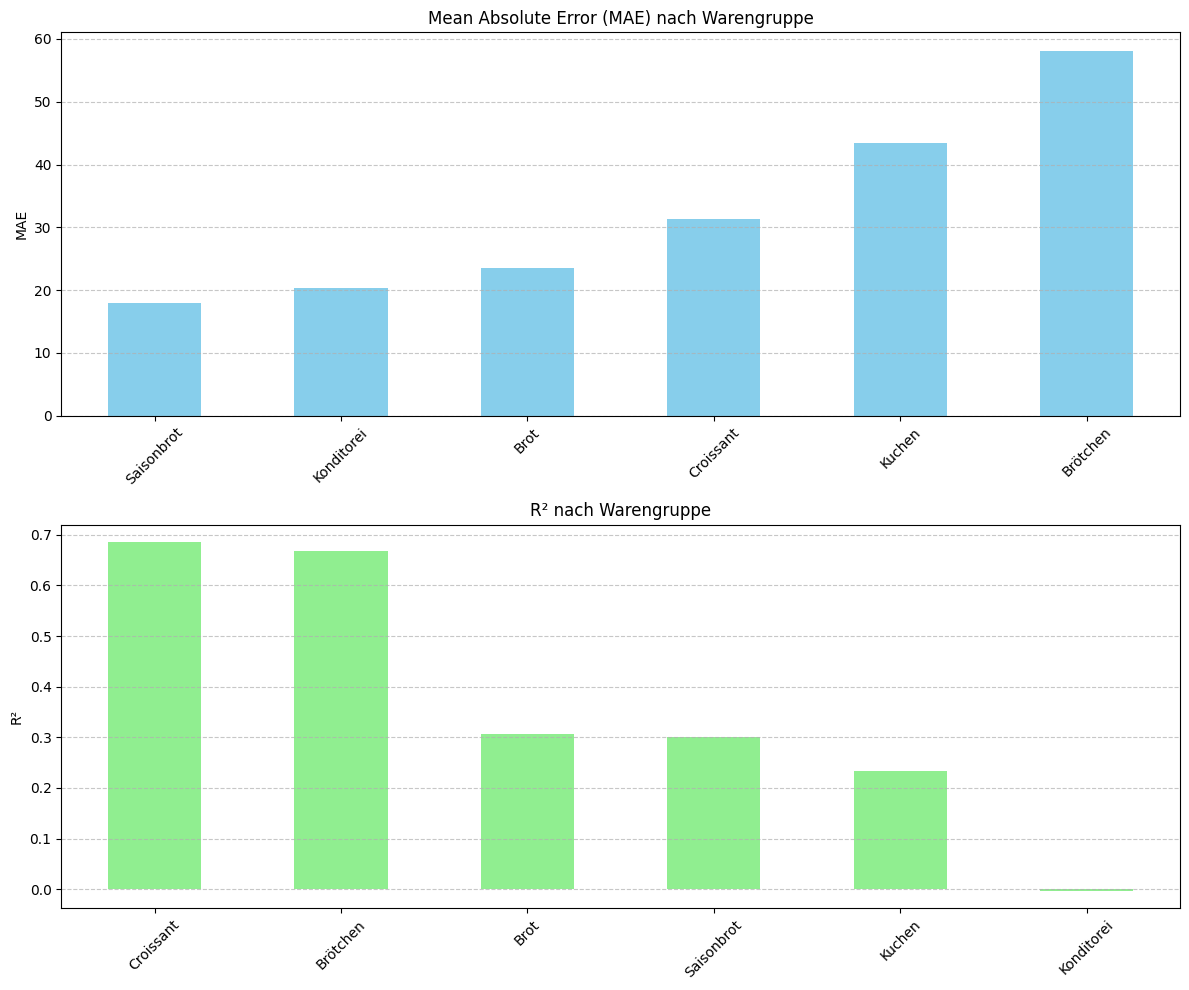

In [69]:
# Visualisierung der Ergebnisse
plt.figure(figsize=(12, 10))

# MAE-Plot
plt.subplot(2, 1, 1)
results_df['MAE'].sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error (MAE) nach Warengruppe')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# R²-Plot
plt.subplot(2, 1, 2)
results_df['R2'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('R² nach Warengruppe')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 7. Vorhersagen auf Testdaten

In [70]:
# Sample Submission laden, um die richtige Reihenfolge zu gewährleisten
sample_submission = pd.read_csv('/workspaces/bakery_sales_prediction/5_Datasets/sample_submission.csv')
print(f"Sample Submission Form: {sample_submission.shape}")
sample_submission.head()

Sample Submission Form: (1830, 2)


,id,Umsatz
0,1808011,0
1,1808021,0
2,1808031,0
3,1808041,0
4,1808051,0


In [71]:
# Funktion zum Extrahieren von Datum und Warengruppe aus ID
def parse_id(id_str):
    """
    Extrahiert Datum und Warengruppe aus der ID im Format YYMMDDW
    YY: Jahr (2-stellig), MM: Monat, DD: Tag, W: Warengruppe
    """
    # Konvertiere zu String, falls es noch nicht ist
    id_str = str(id_str)
    
    # Jahr (2-stellig auf 4-stellig erweitern)
    year = int(id_str[:2])
    year = 2000 + year  # Annahme: Alle Jahre sind 20xx
    
    # Monat und Tag
    month = int(id_str[2:4])
    day = int(id_str[4:6])
    
    # Warengruppe
    warengruppe = int(id_str[6])
    
    # Datum erstellen
    datum = pd.Timestamp(year=year, month=month, day=day)
    
    return datum, warengruppe

In [72]:
# Dictionary für Warengruppen-Mapping (ID zu Name)
warengruppen_map = {
    1: 'Brot',
    2: 'Brötchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Historische Wetterdaten analysieren für bessere Vorhersagen
def analyze_historical_weather_patterns(df):
    """
    Analysiert historische Wettermuster nach Monat und Wochentag
    """
    weather_patterns = {}
    
    for month in range(1, 13):
        month_data = df[df['Datum'].dt.month == month]
        
        if len(month_data) > 0:
            weather_patterns[month] = {
                'temperatur_mean': month_data['Temperatur'].mean(),
                'temperatur_std': month_data['Temperatur'].std(),
                'windgeschwindigkeit_mean': month_data['Windgeschwindigkeit'].mean(),
                'windgeschwindigkeit_std': month_data['Windgeschwindigkeit'].std(),
                'bewoelkung_mean': month_data['Bewoelkung'].mean(),
                'bewoelkung_std': month_data['Bewoelkung'].std()
            }
        else:
            # Fallback für fehlende Monate
            weather_patterns[month] = {
                'temperatur_mean': 10.0,
                'temperatur_std': 5.0,
                'windgeschwindigkeit_mean': 8.0,
                'windgeschwindigkeit_std': 3.0,
                'bewoelkung_mean': 60.0,
                'bewoelkung_std': 15.0
            }
    
    return weather_patterns

def identify_holidays_in_prediction_period():
    """
    Identifiziert Feiertage im Vorhersagezeitraum (Aug 2018 - Jul 2019)
    """
    # Deutsche Feiertage für 2018-2019
    holidays = {
        # 2018
        pd.Timestamp('2018-10-03'): 1,  # Tag der Deutschen Einheit
        pd.Timestamp('2018-10-31'): 1,  # Reformationstag (in SH)
        pd.Timestamp('2018-12-25'): 1,  # 1. Weihnachtstag
        pd.Timestamp('2018-12-26'): 1,  # 2. Weihnachtstag
        
        # 2019
        pd.Timestamp('2019-01-01'): 1,  # Neujahr
        pd.Timestamp('2019-04-19'): 1,  # Karfreitag
        pd.Timestamp('2019-04-22'): 1,  # Ostermontag
        pd.Timestamp('2019-05-01'): 1,  # Tag der Arbeit
        pd.Timestamp('2019-05-30'): 1,  # Christi Himmelfahrt
        pd.Timestamp('2019-06-10'): 1,  # Pfingstmontag
        pd.Timestamp('2019-07-31'): 0,  # Ende des Vorhersagezeitraums (könnte relevant sein)
    }
    
    return holidays

# Wettermuster aus historischen Daten extrahieren
weather_patterns = analyze_historical_weather_patterns(df_processed)
holidays_dict = identify_holidays_in_prediction_period()

print("Historische Wettermuster extrahiert für Monate 1-12")
print(f"Anzahl identifizierter Feiertage: {len(holidays_dict)}")

Historische Wettermuster extrahiert für Monate 1-12
Anzahl identifizierter Feiertage: 11


In [73]:
# Verbesserte Vorhersagefunktion
def generate_weather_prediction(datum, weather_patterns):
    """
    Generiert Wetterdaten basierend auf historischen Mustern
    """
    month = datum.month
    pattern = weather_patterns[month]
    
    # Generiere Werte innerhalb realistischer Bereiche basierend auf historischen Daten
    temperatur = max(-10, min(35, np.random.normal(
        pattern['temperatur_mean'], 
        pattern['temperatur_std'] * 0.5  # Reduzierte Varianz für stabilere Vorhersagen
    )))
    
    windgeschwindigkeit = max(0, min(25, np.random.normal(
        pattern['windgeschwindigkeit_mean'], 
        pattern['windgeschwindigkeit_std'] * 0.5
    )))
    
    bewoelkung = max(0, min(100, np.random.normal(
        pattern['bewoelkung_mean'], 
        pattern['bewoelkung_std'] * 0.5
    )))
    
    return temperatur, windgeschwindigkeit, bewoelkung

# Vorhersagen mit verbesserter Logik generieren
predictions = []
np.random.seed(42)  # Für reproduzierbare Ergebnisse

print("Generiere Vorhersagen basierend auf historischen Datenmustern...")

for idx, row in sample_submission.iterrows():
    id_value = row['id']
    datum, warengruppe_id = parse_id(id_value)
    
    # Warengruppe
    warengruppe_name = warengruppen_map[warengruppe_id]
    
    # Wenn die Warengruppe nicht im Model enthalten ist, mit 0 füllen
    if warengruppe_name not in models:
        predictions.append(0)
        continue
    
    # Wetterdaten basierend auf historischen Mustern generieren
    temp, wind, bewolkung = generate_weather_prediction(datum, weather_patterns)
    
    # Feiertag-Status prüfen
    ist_feiertag = 1 if datum in holidays_dict else 0
    
    # Temporäres DataFrame für diese Vorhersage erstellen
    temp_df = pd.DataFrame({
        'Datum': [datum],
        'Warengruppe_Name': [warengruppe_name],
        'Temperatur': [temp],
        'Windgeschwindigkeit': [wind],
        'Bewoelkung': [bewolkung],
        'ist_feiertag': [ist_feiertag]
    })
    
    # Features erstellen
    temp_df_features = create_features(temp_df)
    
    # Polynomiale Features erstellen
    poly_features_pred = poly.transform(temp_df_features[num_features])
    poly_df_pred = pd.DataFrame(poly_features_pred, columns=poly_feature_names, index=temp_df_features.index)
    
    # Nicht-polynomiale Features behalten, polynomiale hinzufügen
    temp_df_poly = pd.concat([temp_df_features.drop(columns=num_features), poly_df_pred], axis=1)
    
    # Fehlende Features mit 0 füllen (falls welche fehlen)
    for feature in features:
        if feature not in temp_df_poly.columns:
            temp_df_poly[feature] = 0
    
    # Vorhersage machen
    X_pred = temp_df_poly[features]
    prediction = models[warengruppe_name].predict(X_pred)[0]
    
    # Negative Werte auf 0 setzen und extreme Werte begrenzen
    prediction = max(0, min(10000, prediction))  # Realistischer Umsatz-Bereich
    
    predictions.append(prediction)

# Ergebnisse in Sample Submission eintragen
sample_submission['Umsatz'] = predictions

print(f"Vorhersagen generiert für {len(predictions)} Einträge")
print(f"Durchschnittlicher vorhergesagter Umsatz: {np.mean(predictions):.2f}")
print(f"Min/Max Vorhersagen: {np.min(predictions):.2f} / {np.max(predictions):.2f}")

Generiere Vorhersagen basierend auf historischen Datenmustern...
Vorhersagen generiert für 1830 Einträge
Durchschnittlicher vorhergesagter Umsatz: 206.58
Min/Max Vorhersagen: 39.84 / 697.31


In [74]:
# Qualitätskontrolle der Vorhersagen
print("=== QUALITÄTSKONTROLLE DER VORHERSAGEN ===")

# Statistiken nach Warengruppe
pred_stats = {}
for idx, row in sample_submission.iterrows():
    id_value = row['id']
    _, warengruppe_id = parse_id(id_value)
    warengruppe_name = warengruppen_map[warengruppe_id]
    
    if warengruppe_name not in pred_stats:
        pred_stats[warengruppe_name] = []
    pred_stats[warengruppe_name].append(row['Umsatz'])

# Statistiken anzeigen
for wg, values in pred_stats.items():
    print(f"\n{wg}:")
    print(f"  Anzahl Vorhersagen: {len(values)}")
    print(f"  Durchschnitt: {np.mean(values):.2f}")
    print(f"  Median: {np.median(values):.2f}")
    print(f"  Min/Max: {np.min(values):.2f} / {np.max(values):.2f}")
    print(f"  Std: {np.std(values):.2f}")

# Vergleich mit historischen Umsätzen
print(f"\n=== VERGLEICH MIT HISTORISCHEN DATEN ===")
for wg in warengruppen:
    if wg in models:
        hist_data = df_processed[df_processed['Warengruppe_Name'] == wg]['Umsatz']
        pred_data = pred_stats.get(wg, [])
        
        print(f"\n{wg}:")
        print(f"  Historischer Durchschnitt: {hist_data.mean():.2f}")
        print(f"  Vorhergesagter Durchschnitt: {np.mean(pred_data):.2f}")
        print(f"  Verhältnis (Pred/Hist): {np.mean(pred_data)/hist_data.mean():.2f}")

# Speichern der finalen Vorhersagen
sample_submission.to_csv('/workspaces/bakery_sales_prediction/3_Model/prediction_linear_regression_advanced.csv', index=False)
print(f"\nVorhersagen gespeichert in: /workspaces/bakery_sales_prediction/3_Model/prediction_linear_regression_advanced.csv")
sample_submission.head()

=== QUALITÄTSKONTROLLE DER VORHERSAGEN ===

Brot:
  Anzahl Vorhersagen: 355
  Durchschnitt: 121.65
  Median: 126.16
  Min/Max: 51.10 / 165.44
  Std: 25.09

Brötchen:
  Anzahl Vorhersagen: 355
  Durchschnitt: 405.23
  Median: 384.89
  Min/Max: 241.84 / 697.31
  Std: 105.23

Croissant:
  Anzahl Vorhersagen: 355
  Durchschnitt: 161.76
  Median: 143.73
  Min/Max: 79.76 / 307.95
  Std: 57.85

Konditorei:
  Anzahl Vorhersagen: 354
  Durchschnitt: 89.72
  Median: 80.15
  Min/Max: 64.40 / 175.14
  Std: 23.68

Kuchen:
  Anzahl Vorhersagen: 355
  Durchschnitt: 275.79
  Median: 269.48
  Min/Max: 212.90 / 374.90
  Std: 34.33

Saisonbrot:
  Anzahl Vorhersagen: 56
  Durchschnitt: 69.85
  Median: 71.51
  Min/Max: 39.84 / 90.97
  Std: 11.81

=== VERGLEICH MIT HISTORISCHEN DATEN ===

Brot:
  Historischer Durchschnitt: 122.19
  Vorhergesagter Durchschnitt: 121.65
  Verhältnis (Pred/Hist): 1.00

Brötchen:
  Historischer Durchschnitt: 399.21
  Vorhergesagter Durchschnitt: 405.23
  Verhältnis (Pred/Hist): 

,id,Umsatz
0,1808011,135.661085
1,1808021,152.719949
2,1808031,145.267462
3,1808041,162.236022
4,1808051,85.976451
